In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2024-07-17 23:57:23.247597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 23:57:23.264879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 23:57:23.264928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 23:57:23.278547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 23:57:23.832562: W tensorflow/compiler/tf

In [2]:
# First get our data for csv.
df = pd.read_csv('BTCUSDT.csv')

In [3]:
# Gets all of our averages.

def get_averages(data):

    # only take close and open and time
    data = data[['Close', 'Open', 'Open time']]

    data['MA15'] = data['Close'].rolling(window=5).mean()

    # data['MA20'] = data['Close'].rolling(window=20).mean()

    data['MA60'] = data['Close'].rolling(window=60).mean()

    # data['MA720'] = data['Close'].rolling(window=720).mean()

    data['MA1440'] = data['Close'].rolling(window=1440).mean()

    data['MA10080'] = data['Close'].rolling(window=10080).mean()

    # data['MA131400'] = data['Close'].rolling(window=131400).mean()

    # Drop if even one of the values is na
    data = data.dropna()

    newdata = data[['Close', 'MA15', 'MA60', 'MA1440', 'MA10080']].values

    return newdata


In [4]:
def normalise_averages(averages):
    
    # get max close from data
    max_close = averages[:, 0].max()
    # get min close from data
    min_close = averages[:, 0].min()

    for i in range(averages.shape[1]):
        averages[:, i] = (averages[:, i] - min_close) / (max_close - min_close)

    return averages

avg = get_averages(df)

#print (avg.shape)

avg = normalise_averages(avg)

#print(avg)

/tmp/ipykernel_9627/2824517797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA15'] = data['Close'].rolling(window=5).mean()
/tmp/ipykernel_9627/2824517797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA60'] = data['Close'].rolling(window=60).mean()
/tmp/ipykernel_9627/2824517797.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [5]:
def create_sequences(data, seq_length, future_steps):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-future_steps):
        x = data[i:i+seq_length]
        # y is the mean over the next future_steps entries
        y = np.mean(data[i+seq_length:i+seq_length+future_steps, 0])
        # print(x.shape)
        # print(y)
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 60  # Example: 50 days of past data
future_steps = 5  # Predicting the next 5 closing prices

x, y = create_sequences(avg, seq_length, future_steps)
#print(x.shape)

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,losses

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now we create a RNN model

# Create model

model = models.Sequential()

model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 5)))

#model.add(layers.LSTM(units=100, return_sequences=True))

model.add(layers.LSTM(units=50, return_sequences=False))

model.add(layers.Dropout(0.01))

model.add(layers.Dense(25))

model.add(layers.Dense(1))  # Output layer with future_steps units

model.compile(optimizer='adam',
              loss=losses.MeanAbsolutePercentageError(),
              metrics=[losses.MeanAbsoluteError()])


2024-07-17 23:57:41.968313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 23:57:41.968532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 23:57:41.968734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
batchsize = x_train.shape[0] // 120

#print(batchsize)

#More epochs
history = model.fit(x_train, y_train, epochs=20, batch_size=batchsize, validation_data=(x_test, y_test))



Epoch 1/20


2024-07-17 23:57:51.660608: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 672ms/step - loss: 17.3316 - mean_absolute_error: 0.0334 - val_loss: 0.7449 - val_mean_absolute_error: 0.0029
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 79s 652ms/step - loss: 2.8373 - mean_absolute_error: 0.0054 - val_loss: 0.8644 - val_mean_absolute_error: 0.0032
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 79s 655ms/step - loss: 2.3008 - mean_absolute_error: 0.0047 - val_loss: 1.1241 - val_mean_absolute_error: 0.0043
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s 658ms/step - loss: 2.1629 - mean_absolute_error: 0.0046 - val_loss: 1.2232 - val_mean_absolute_error: 0.0047
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s 656ms/step - loss: 2.4859 - mean_absolute_error: 0.0048 - val_loss: 0.1825 - val_mean_absolute_error: 7.1309e-04
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 79s 655ms/step - loss: 2.0881 - mean_absolute_error: 0.0043 - val_loss: 0.9260 - val_mean_absolute_error: 0.0035
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 79s 654ms/step - loss: 2.1669 - mean_absolute_er

In [12]:
# Save the weights
model.save('BTCUSD_close_60p_5m_rolling_v2.keras')

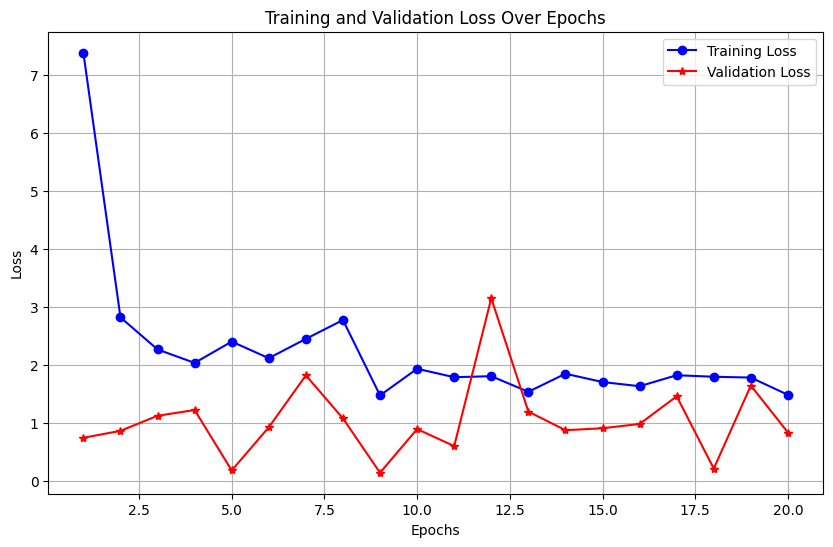

In [9]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# save the model
model.save('BTCUSD_close_80p_10m.keras')